In [ ]:
# import sympy

In [ ]:
# demo of sympy
from sympy.core.symbol import symbols
from sympy.solvers.solveset import nonlinsolve
x, y = symbols('x, y', real=True)
nonlinsolve([4*x, 2*x*y - 6*y**2 + 2*y], [x, y])

In [ ]:
# first im ignoring death rate and combining the two infection rates
# suseptible, infected, recovered, and dead
s, i, r, d = symbols('s, i, r, d', real=True)
# b is infection rate
# N is total population
# a (alpha) is rate recovered population turns suseptible again
# d1 is the death rate of infected indivual
b, N, a, d1 = symbols('b, N, a, d1', real=True)
nonlinsolve([(-b*s*i)/N, (b*s*i)/N - r*i - d1*i, r*i - a*r, d1*i], [s, i, r, d])

In [89]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [107]:
agency_df = pd.read_csv("https://raw.githubusercontent.com/pfflanders/california-coronavirus-data/master/latimes-state-totals.csv", parse_dates=["date"])
agency_df.head()

,date,confirmed_cases,deaths,new_confirmed_cases,new_deaths
0,2021-09-02,4363257,65596,11920.0,140.0
1,2021-09-01,4351337,65456,16692.0,174.0
2,2021-08-31,4334645,65282,22701.0,77.0
3,2021-08-30,4311944,65205,21070.0,82.0
4,2021-08-29,4290874,65123,3620.0,25.0


In [212]:
N = 40000000 # population of california

b = 0.05 # terrible approximation of rate of covid transmission. 
d1 = 0.0001 # approx death rate of covid
r1 = 0.03 # rate of infected population recovering
a = 0.03 # rate of recovered -> suseptible

steps = 586 # days since start of covid

In [213]:
def sirs(t, z, N, b, d1, r1, a):
    """
    t: time step
    z: Tuple of ints: (s, i, r, d) 
    b: approximate rate of covid transmission
    N: total population of sim
    a: rate of recovered -> suseptible
    d1: death rate of infected individuals
    
    """
    s, i, r, d = z
    return [
        (-b*s*i)/N + a*r,        # ds/dt
        ( b*s*i)/N - r1*i - d1*i, # di/dt
        r1*i - a*r,               # dr/dt
        d1*i                     # d(dead)/dt
    ]

In [214]:
sol = solve_ivp(fun=sirs, 
                t_span=[0, steps],
                y0=[N-100, 1000, 0, 0],
                args=(N, b, d1, r1, a),
                dense_output=True)

In [215]:
t = np.linspace(0, steps, steps)


In [216]:
z = sol.sol(t)


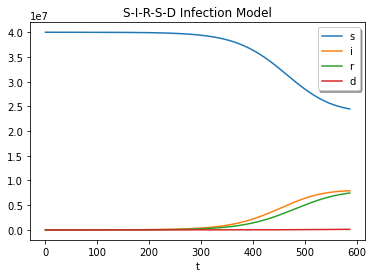

In [217]:
plt.plot(t, z.T)

plt.xlabel('t')
plt.legend(['s', 'i', 'r', 'd'], shadow=True)
#plt.yscale('log')
plt.title('S-I-R-S-D Infection Model')
plt.show()

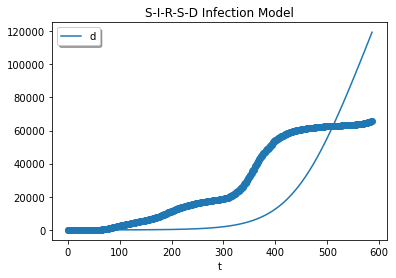

In [218]:
plt.plot(t, z[3].T)
plt.scatter(agency_df['date'].apply(lambda x: x.value/10**9/60/60/24 - 18287.0), agency_df["deaths"])
plt.xlabel('t')
plt.legend(['d'], shadow=True)
#plt.yscale('log')
plt.title('S-I-R-S-D Infection Model')
plt.show()


0      585.0
1      584.0
2      583.0
3      582.0
4      581.0
       ...  
581      4.0
582      3.0
583      2.0
584      1.0
585      0.0
Name: date, Length: 586, dtype: float64